In [10]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import h5py
import pickle
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
from scipy.integrate import simps
from scipy.optimize import minimize
import emcee
import corner
from lal import C_SI
plt.rcParams.update({'font.size': 15})
matplotlib.rcParams['text.usetex'] = True

%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [11]:
def dipole_cal(g, ra, dec, l=264, b=48):
    dipole_gal = SkyCoord(l*u.deg, b*u.deg, frame='galactic')
    dipole_ICRS = dipole_gal.transform_to('icrs')

    phi_dipole = dipole_ICRS.ra.value*np.pi/180
    theta_dipole = np.pi/2-dipole_ICRS.dec.value*np.pi/180

    nx_dipole = np.cos(phi_dipole)*np.sin(theta_dipole)
    ny_dipole = np.sin(phi_dipole)*np.sin(theta_dipole)
    nz_dipole = np.cos(theta_dipole)

    phi = ra
    theta = np.pi/2-np.array(dec)

    nx = np.cos(phi)*np.sin(theta)
    ny = np.sin(phi)*np.sin(theta)
    nz = np.cos(theta)

    dipole = g*(nx_dipole*nx + ny_dipole*ny + nz_dipole*nz)

    return dipole

In [12]:
fr = open("/home/ansonchen/cosmic_dipole_gw/XG_A#_golden/seed_1/BBH/GW_injections_XG_A#.p", "rb")
XG_BBH_inj = pickle.load(fr)
fr.close()

In [13]:
fr = open("/home/ansonchen/cosmic_dipole_gw/XG_A#_golden/seed_1/NSBH/GW_injections_XG_A#.p", "rb")
XG_NSBH_inj = pickle.load(fr)
fr.close()

In [14]:
fr = open("/home/ansonchen/cosmic_dipole_gw/XG_A#_golden/seed_1/BNS/GW_injections_XG_A#.p", "rb")
XG_BNS_inj = pickle.load(fr)
fr.close()

In [15]:
dl_0_BBH = XG_BBH_inj['injections_parameters']['dls']
dl_0_NSBH = XG_NSBH_inj['injections_parameters']['dls']
dl_0_BNS = XG_BNS_inj['injections_parameters']['dls']

In [16]:
XG_BBH_inj['injections_parameters']['dets_pe']

[array(['V1'], dtype='<U2'),
 array(['H1', 'L1', 'V1'], dtype='<U2'),
 array(['H1', 'V1'], dtype='<U2'),
 array(['L1', 'V1'], dtype='<U2'),
 array(['L1', 'V1'], dtype='<U2'),
 array(['V1'], dtype='<U2'),
 array(['L1', 'V1'], dtype='<U2'),
 array(['H1', 'L1', 'V1'], dtype='<U2'),
 array(['H1', 'L1', 'V1'], dtype='<U2'),
 array(['H1', 'L1', 'V1'], dtype='<U2'),
 array(['H1', 'L1'], dtype='<U2'),
 array(['H1', 'V1'], dtype='<U2'),
 array(['H1', 'V1'], dtype='<U2'),
 array(['L1'], dtype='<U2'),
 array(['H1', 'L1', 'V1'], dtype='<U2'),
 array(['H1', 'L1', 'V1'], dtype='<U2'),
 array(['H1', 'L1', 'V1'], dtype='<U2'),
 array(['H1', 'V1'], dtype='<U2'),
 array(['H1', 'L1', 'V1'], dtype='<U2'),
 array(['L1'], dtype='<U2'),
 array(['L1', 'V1'], dtype='<U2'),
 array(['H1', 'L1', 'V1'], dtype='<U2'),
 array(['V1'], dtype='<U2'),
 array(['H1', 'L1'], dtype='<U2'),
 array(['H1', 'L1', 'V1'], dtype='<U2'),
 array(['H1', 'V1'], dtype='<U2'),
 array(['H1', 'V1'], dtype='<U2'),
 array(['H1', 'L1', 'V1']

In [17]:
index_BBH = []
index_NSBH = []
index_BNS = []

for i in range(len(dl_0_BBH)):
    try:
        data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_A#_golden_seed_1_g0p001/BBH_cov_{i}.txt')
        if len(XG_BBH_inj['injections_parameters']['dets_pe'][i])>1 and 4*4*np.sqrt(data[4,4])*np.sqrt(data[5,5])*180*180/np.pi/np.pi<0.06 and dl_0_BBH[i]<461:
            index_BBH.append(i)
    except:
        continue

for i in range(len(dl_0_NSBH)):
    try:
        data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_A#_golden_seed_1_g0p001/NSBH_cov_{i}.txt')
        if len(XG_NSBH_inj['injections_parameters']['dets_pe'][i])>1 and 4*4*np.sqrt(data[4,4])*np.sqrt(data[5,5])*180*180/np.pi/np.pi<0.06 and dl_0_NSBH[i]<461:
            index_NSBH.append(i)
    except:
        continue

for i in range(len(dl_0_BNS)):
    try:
        data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_A#_golden_seed_1_g0p001/BNS_cov_{i}.txt')
        if len(XG_BNS_inj['injections_parameters']['dets_pe'][i])>1 and 4*4*np.sqrt(data[4,4])*np.sqrt(data[5,5])*180*180/np.pi/np.pi<0.06 and dl_0_BNS[i]<461:
            index_BNS.append(i)
    except:
        continue


In [18]:
len(index_BBH),len(index_NSBH),len(index_BNS)

(31, 2, 2)

In [19]:
index_BBH

[1,
 3,
 7,
 8,
 9,
 14,
 15,
 16,
 17,
 18,
 21,
 24,
 27,
 28,
 29,
 30,
 32,
 33,
 36,
 37,
 39,
 42,
 43,
 44,
 46,
 48,
 50,
 51,
 53,
 54,
 57]

In [20]:
index_NSBH

[6, 23]

In [21]:
index_BNS

[40, 44]

In [22]:
# samples = [0]*(len(index_BBH)+len(index_NSBH)+len(index_BNS))
# for i,ind in enumerate(index_BBH):
#     samples[i] = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/Fisher_sampler_XG_golden_seed_1_g0p001/BBH_Fisher_samples_{ind}.dat', names=True)
# for i,ind in enumerate(index_NSBH):
#     samples[len(index_BBH)+i] = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/Fisher_sampler_XG_golden_seed_1_g0p001/NSBH_Fisher_samples_{ind}.dat', names=True)
# for i,ind in enumerate(index_BNS):
#     samples[len(index_BBH)+len(index_NSBH)+i] = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/Fisher_sampler_XG_golden_seed_1_g0p001/BNS_Fisher_samples_{ind}.dat', names=True)


In [23]:
index_all = np.append(np.append(np.array(index_BBH),np.array(index_NSBH)),np.array(index_BNS))

In [24]:
# fig = plt.figure(figsize=(26,25))
# gs = gridspec.GridSpec(10, 8, wspace=0.1)

# for i in range(0,10):
#     for j in range(0,8):

#         if 8*i+j >= len(index_BBH)+len(index_NSBH)+len(index_BNS):
#             break

#         ax = plt.subplot(gs[8*i+j])
#         plt.title('event %d'%index_all[8*i+j])

#         plt.hist(samples[8*i+j]['ra']/np.pi*180,bins=50,histtype='step')

#         plt.axvline(np.mean(samples[8*i+j]['ra']/np.pi*180),color='k',linestyle='--',alpha=0.6)

#         if j==0:
#             ax.set_ylabel('likelihood',fontsize=15)

#         ax.set_yticklabels([])
#         # plt.xlim(10,200)
#         plt.ylim(bottom=0)

In [25]:
# fig = plt.figure(figsize=(26,25))
# gs = gridspec.GridSpec(10, 8, wspace=0.1)

# for i in range(0,10):
#     for j in range(0,8):

#         if 8*i+j >= len(index_BBH)+len(index_NSBH)+len(index_BNS):
#             break

#         ax = plt.subplot(gs[8*i+j])
#         plt.title('event %d'%index_all[8*i+j])

#         plt.hist(samples[8*i+j]['dec']/np.pi*180,bins=50,histtype='step')

#         plt.axvline(np.mean(samples[8*i+j]['dec']/np.pi*180),color='k',linestyle='--',alpha=0.6)

#         if j==0:
#             ax.set_ylabel('likelihood',fontsize=15)

#         ax.set_yticklabels([])
#         # plt.xlim(10,200)
#         plt.ylim(bottom=0)

In [26]:
# ra_std = [0]*len(index_all)
# dec_std = [0]*len(index_all)
# ra_mean = [0]*len(index_all)
# dec_mean = [0]*len(index_all)
# for i in range(len(index_all)):
#     ra_std[i] = np.std(samples[i]['ra'])
#     dec_std[i] = np.std(samples[i]['dec'])
#     ra_mean[i] = np.mean(samples[i]['ra'])
#     dec_mean[i] = np.mean(samples[i]['dec'])

In [27]:
zs = [0]*len(index_all)
ra_mean = [0]*len(index_all)
dec_mean = [0]*len(index_all)

for i,ind in enumerate(index_BBH):
    zs[i] = XG_BBH_inj['injections_parameters']['zs'][ind]
    ra_mean[i] = XG_BBH_inj['injections_parameters']['ras'][ind]
    dec_mean[i] = XG_BBH_inj['injections_parameters']['decs'][ind]
for i,ind in enumerate(index_NSBH):
    zs[len(index_BBH)+i] = XG_NSBH_inj['injections_parameters']['zs'][ind]
    ra_mean[len(index_BBH)+i] = XG_NSBH_inj['injections_parameters']['ras'][ind]
    dec_mean[len(index_BBH)+i] = XG_NSBH_inj['injections_parameters']['decs'][ind]
for i,ind in enumerate(index_BNS):
    zs[len(index_BBH)+len(index_NSBH)+i] = XG_BNS_inj['injections_parameters']['zs'][ind]
    ra_mean[len(index_BBH)+len(index_NSBH)+i] = XG_BNS_inj['injections_parameters']['ras'][ind]
    dec_mean[len(index_BBH)+len(index_NSBH)+i] = XG_BNS_inj['injections_parameters']['decs'][ind]

In [28]:
g=0.001

z0 = [0]*len(index_all)
for i,ind in enumerate(index_BBH):
    z0[i] = (1+zs[i]) * (1+dipole_cal(g, XG_BBH_inj['injections_parameters']['ras'][ind], XG_BBH_inj['injections_parameters']['decs'][ind])) -1
for i,ind in enumerate(index_NSBH):
    z0[len(index_BBH)+i] = (1+zs[len(index_BBH)+i]) * (1+dipole_cal(g, XG_NSBH_inj['injections_parameters']['ras'][ind], XG_NSBH_inj['injections_parameters']['decs'][ind])) -1
for i,ind in enumerate(index_BNS):
    z0[len(index_BBH)+len(index_NSBH)+i] = (1+zs[len(index_BBH)+len(index_NSBH)+i]) * (1+dipole_cal(g, XG_BNS_inj['injections_parameters']['ras'][ind], XG_BNS_inj['injections_parameters']['decs'][ind])) -1


In [29]:
ra_std = [0]*len(index_all)
dec_std = [0]*len(index_all)

for i,ind in enumerate(index_BBH):
    data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_A#_golden_seed_1_g0p001/BBH_cov_{ind}.txt')
    ra_std[i] = np.sqrt(data[4,4])
    dec_std[i] = np.sqrt(data[5,5])
for i,ind in enumerate(index_NSBH):
    data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_A#_golden_seed_1_g0p001/NSBH_cov_{ind}.txt')
    ra_std[len(index_BBH)+i] = np.sqrt(data[4,4])
    dec_std[len(index_BBH)+i] = np.sqrt(data[5,5])
for i,ind in enumerate(index_BNS):
    data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_A#_golden_seed_1_g0p001/BNS_cov_{ind}.txt')
    ra_std[len(index_BBH)+len(index_NSBH)+i] = np.sqrt(data[4,4])
    dec_std[len(index_BBH)+len(index_NSBH)+i] = np.sqrt(data[5,5])    

In [30]:
np.array(ra_std)/np.pi*180

array([0.04885821, 0.09809105, 0.01536782, 0.02553535, 0.04004291,
       0.02138264, 0.02142533, 0.03686102, 0.1063344 , 0.02605009,
       0.03457846, 0.07222626, 0.05843299, 0.12551799, 0.03304201,
       0.06634135, 0.02061508, 0.01855325, 0.01221388, 0.03474699,
       0.03991323, 0.01513818, 0.03305157, 0.09699196, 0.02346749,
       0.05114143, 0.00525719, 0.04597361, 0.03969222, 0.03348752,
       0.06361256, 0.04408596, 0.06145631, 0.02061279, 0.08598184])

In [31]:
np.array(dec_std)/np.pi*180

array([0.00766979, 0.03326312, 0.05557495, 0.02158155, 0.01256378,
       0.034734  , 0.0154085 , 0.02817806, 0.01595979, 0.02549321,
       0.06170065, 0.0426154 , 0.05165414, 0.02009216, 0.02559866,
       0.01902993, 0.01921342, 0.04769926, 0.15751543, 0.06732126,
       0.03509796, 0.0205691 , 0.03260613, 0.01996392, 0.01193554,
       0.062148  , 0.00461509, 0.01268397, 0.02782236, 0.00728297,
       0.01426093, 0.05117514, 0.04997103, 0.12504413, 0.03546581])

In [32]:
np.array(ra_std)/np.pi*180*np.array(dec_std)/np.pi*180

array([3.74732388e-04, 3.26281489e-03, 8.54065681e-04, 5.51092489e-04,
       5.03090465e-04, 7.42704697e-04, 3.30132242e-04, 1.03867188e-03,
       1.69707518e-03, 6.64100290e-04, 2.13351322e-03, 3.07795109e-03,
       3.01830583e-03, 2.52192753e-03, 8.45831079e-04, 1.26247132e-03,
       3.96086193e-04, 8.84976230e-04, 1.92387424e-03, 2.33921097e-03,
       1.40087289e-03, 3.11378881e-04, 1.07768353e-03, 1.93633960e-03,
       2.80097157e-04, 3.17833738e-03, 2.42623872e-05, 5.83127777e-04,
       1.10433120e-03, 2.43888632e-04, 9.07174216e-04, 2.25610549e-03,
       3.07103534e-03, 2.57750879e-03, 3.04941586e-03])

In [33]:
dl_mean = [0]*len(index_all)
dl_std = [0]*len(index_all)

for i,ind in enumerate(index_BBH):
    dl_mean[i] = dl_0_BBH[ind] * (1+dipole_cal(g, XG_BBH_inj['injections_parameters']['ras'][ind], XG_BBH_inj['injections_parameters']['decs'][ind]))
    data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_A#_golden_seed_1_g0p001/BBH_cov_{ind}.txt')
    dl_std[i] = np.sqrt(data[2,2])
for i,ind in enumerate(index_NSBH):
    dl_mean[len(index_BBH)+i] = dl_0_NSBH[ind] * (1+dipole_cal(g, XG_NSBH_inj['injections_parameters']['ras'][ind], XG_NSBH_inj['injections_parameters']['decs'][ind]))
    data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_A#_golden_seed_1_g0p001/NSBH_cov_{ind}.txt')
    dl_std[len(index_BBH)+i] = np.sqrt(data[2,2])
for i,ind in enumerate(index_BNS):
    dl_mean[len(index_BBH)+len(index_NSBH)+i] = dl_0_BNS[ind] * (1+dipole_cal(g, XG_BNS_inj['injections_parameters']['ras'][ind], XG_BNS_inj['injections_parameters']['decs'][ind])) 
    data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_A#_golden_seed_1_g0p001/BNS_cov_{ind}.txt')
    dl_std[len(index_BBH)+len(index_NSBH)+i] = np.sqrt(data[2,2])
 
    # dl_mean[i] = np.mean(samples[i]['luminosity_distance'])
    # dl_std[i] = np.std(samples[i]['luminosity_distance'])

In [68]:
def chi2_dl_dipole(glb, ra_arr, dec_arr, zs_arr, dl_mean, dl_std, H0=70, Om0=0.3):
    g = glb[0]
    l = glb[1]
    b = glb[2]
    
    dipole_gal = SkyCoord(l*u.deg, b*u.deg, frame='galactic')
    dipole_ICRS = dipole_gal.transform_to('icrs')

    phi_dipole = dipole_ICRS.ra.value*np.pi/180
    theta_dipole = np.pi/2-dipole_ICRS.dec.value*np.pi/180

    nx_dipole = np.cos(phi_dipole)*np.sin(theta_dipole)
    ny_dipole = np.sin(phi_dipole)*np.sin(theta_dipole)
    nz_dipole = np.cos(theta_dipole)

    chi2 = 0

    for i in range(len(ra_arr)):
        phi = ra_arr[i]
        theta = np.pi/2-np.array(dec_arr[i])

        nx = np.cos(phi)*np.sin(theta)
        ny = np.sin(phi)*np.sin(theta)
        nz = np.cos(theta)

        dipole = g*(nx_dipole*nx + ny_dipole*ny + nz_dipole*nz)

        astropy_cosmology = FlatLambdaCDM(Om0=Om0,H0=H0)
        zt = (1+zs_arr[i])/(1+dipole) -1
        dl_0 = astropy_cosmology.luminosity_distance(zt).value
        dl_g = dl_0*(1+dipole)

        chi2 += (dl_mean[i]-dl_g)**2 / dl_std[i]**2

    return chi2


In [69]:
chi2_dl_dipole([1.250e-04, 268, 48], ra_mean, dec_mean, z0, dl_mean, dl_std, H0=70, Om0=0.3)

308.59034448044486

In [70]:
minimize(chi2_dl_dipole, [0,268,48], args=(ra_mean, dec_mean, z0, dl_mean, dl_std), method='Nelder-Mead')

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 3.075029646502359e-11
             x: [ 1.000e-03  2.640e+02  4.800e+01]
           nit: 92
          nfev: 172
 final_simplex: (array([[ 1.000e-03,  2.640e+02,  4.800e+01],
                       [ 1.000e-03,  2.640e+02,  4.800e+01],
                       [ 1.000e-03,  2.640e+02,  4.800e+01],
                       [ 1.000e-03,  2.640e+02,  4.800e+01]]), array([ 3.075e-11,  4.476e-11,  6.545e-11,  1.366e-10]))

In [71]:
# cov_index = [0]*len(index)
# for i,ind in enumerate(index):
#     cov_data = np.loadtxt(f'covariance_XG_snr500/cov_{ind}.txt')
#     cov_index[i] = np.zeros((3,3))
#     cov_index[i][0,0] = cov_data[2,2]
#     cov_index[i][0,1:] = cov_data[2,4:]
#     cov_index[i][1:,0] = cov_data[4:,2]
#     cov_index[i][1:,1:] = cov_data[4:,4:]

In [72]:
def logprob_dl_g(glb, ra_arr, dec_arr, zs_arr, dl_mean, dl_std, H0=70, Om0=0.3):
    g = glb[0]
    l = glb[1]
    b = glb[2]

    if 0<=g<1 and 0<=l<360 and -90<=b<=90:

        dipole_gal = SkyCoord(l*u.deg, b*u.deg, frame='galactic')
        dipole_ICRS = dipole_gal.transform_to('icrs')

        phi_dipole = dipole_ICRS.ra.value*np.pi/180
        theta_dipole = np.pi/2-dipole_ICRS.dec.value*np.pi/180

        nx_dipole = np.cos(phi_dipole)*np.sin(theta_dipole)
        ny_dipole = np.sin(phi_dipole)*np.sin(theta_dipole)
        nz_dipole = np.cos(theta_dipole)

        chi2 = 0

        for i in range(len(ra_arr)):
            phi = ra_arr[i]
            theta = np.pi/2-np.array(dec_arr[i])

            nx = np.cos(phi)*np.sin(theta)
            ny = np.sin(phi)*np.sin(theta)
            nz = np.cos(theta)

            dipole = g*(nx_dipole*nx + ny_dipole*ny + nz_dipole*nz)

            astropy_cosmology = FlatLambdaCDM(Om0=Om0,H0=H0)
            zt = (1+zs_arr[i])/(1+dipole) -1
            dl_0 = astropy_cosmology.luminosity_distance(zt).value
            dl_g = dl_0*(1+dipole)

            # x = np.array([dl_g, ra_arr[i], dec_arr[i]])
            # mu = np.array([dl_mean[i], ra_arr[i], dec_arr[i]])
            # diff = x - mu
            
            # chi2 += np.dot(diff, np.linalg.solve(cov_matrix, diff))
            chi2 += (dl_mean[i]-dl_g)**2 / dl_std[i]**2
        
        logprob = -0.5*chi2

    else:
        logprob = -np.inf

    return logprob


In [73]:
nwalkers = 32
ndim = 3
p0 = np.random.rand(nwalkers, ndim)*np.array([1,360,180]) - np.array([0,0,90])
print(p0)

[[ 7.95039686e-01  1.63241233e+02 -4.00953713e+01]
 [ 8.90702481e-01  2.29694733e+02  7.32063256e+01]
 [ 5.32189438e-01  3.55931438e+02 -7.18929465e+01]
 [ 1.85839491e-01  3.42044418e+01 -5.23820014e+01]
 [ 8.34641882e-01  3.38929110e+02 -4.32005688e+00]
 [ 8.89112986e-01  2.46174510e+02 -2.97725148e+01]
 [ 9.41747990e-02  1.55954961e+02 -5.34841017e+01]
 [ 5.99517702e-01  1.63133977e+02  2.54055013e+01]
 [ 2.88089835e-01  5.68423411e+01  8.56224485e+01]
 [ 5.45517043e-01  2.38324983e+02  4.74751822e+01]
 [ 9.98534136e-01  3.14994616e+02 -4.60534884e+01]
 [ 2.65644865e-01  5.84046780e+01 -7.41746827e+01]
 [ 3.84537214e-01  2.88744418e+02  8.22846540e+01]
 [ 3.29464589e-01  5.94407376e+01  2.67058291e+01]
 [ 7.79658495e-01  1.21516410e+02  6.52093024e+01]
 [ 5.83588766e-01  2.66142854e+02  3.48149071e+01]
 [ 1.61255890e-01  1.80052738e+01  3.67774084e+01]
 [ 8.50586039e-01  3.25548457e+02  3.09738628e+01]
 [ 2.21227196e-01  4.99276923e+01  4.61462469e+01]
 [ 6.41189055e-01  2.50733545e+

In [74]:
logprob_dl_g(p0[0], ra_mean, dec_mean, z0, dl_mean, dl_std)

-220528444.1254398

In [75]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob_dl_g, args=[ra_mean, dec_mean, z0, dl_mean, dl_std])


In [76]:
state = sampler.run_mcmc(p0, 100)
# sampler.reset()

(array([1.439e+03, 2.500e+02, 1.200e+02, 1.250e+02, 5.200e+01, 1.190e+02,
        5.200e+01, 5.700e+01, 6.000e+01, 3.700e+01, 4.100e+01, 2.600e+01,
        8.000e+00, 3.100e+01, 4.200e+01, 2.700e+01, 4.900e+01, 9.000e+00,
        3.500e+01, 1.200e+01, 2.100e+01, 1.400e+01, 2.300e+01, 2.300e+01,
        2.500e+01, 1.700e+01, 6.000e+00, 1.200e+01, 1.100e+01, 1.300e+01,
        1.200e+01, 1.600e+01, 1.300e+01, 4.100e+01, 1.000e+00, 1.000e+00,
        1.900e+01, 9.000e+00, 1.700e+01, 1.500e+01, 1.300e+01, 7.000e+00,
        2.100e+01, 5.000e+00, 5.000e+00, 3.000e+00, 1.000e+00, 3.000e+00,
        6.000e+00, 1.900e+01, 9.000e+00, 2.400e+01, 4.000e+00, 6.000e+00,
        0.000e+00, 1.000e+00, 1.000e+01, 2.800e+01, 4.000e+00, 4.000e+01,
        1.500e+01, 0.000e+00, 4.000e+00, 1.000e+01, 4.000e+00, 0.000e+00,
        4.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.900e+01, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00, 0.000e+0

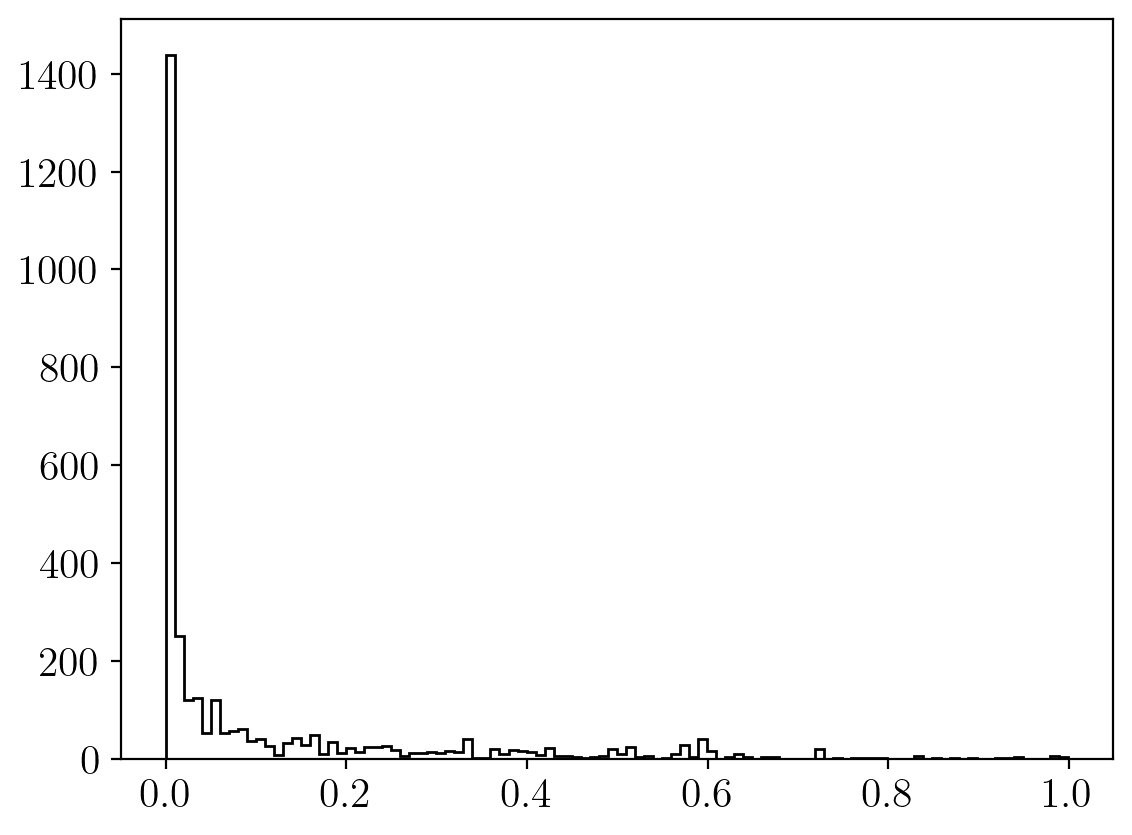

In [77]:
samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 0], 100, color="k", histtype="step")

(array([ 30.,  23.,   5.,  13.,  21.,  16.,  20.,  18.,  11.,  29.,  11.,
          6.,  26.,   3.,  72.,  26.,  35.,  17.,  23.,  10.,  15.,  17.,
         11.,  15.,   6.,  17.,  19.,  12.,  12.,  26.,  22.,  16.,  44.,
         63.,  27.,  13.,  13.,  41.,  33.,  37.,  20.,  50.,  35.,  49.,
         44.,  40.,  74.,  82.,  52.,  54.,  59.,  88.,  71.,  52.,  71.,
         99.,  54.,  39.,  36., 139.,  54.,  76.,  75.,  51.,  70.,  53.,
         76., 109., 105.,  42.,  40.,  64.,  41.,  24.,  32.,  57.,  14.,
          7.,  25.,   6.,   6.,  12.,   6.,   4.,   5.,   1.,   4.,  10.,
          4.,   4.,   4.,  11.,   8.,   4.,   0.,   0.,  11.,   1.,   1.,
          1.]),
 array([2.23055513e-01, 3.74722213e+00, 7.27138874e+00, 1.07955554e+01,
        1.43197220e+01, 1.78438886e+01, 2.13680552e+01, 2.48922218e+01,
        2.84163884e+01, 3.19405550e+01, 3.54647216e+01, 3.89888883e+01,
        4.25130549e+01, 4.60372215e+01, 4.95613881e+01, 5.30855547e+01,
        5.66097213e+01, 6.0133

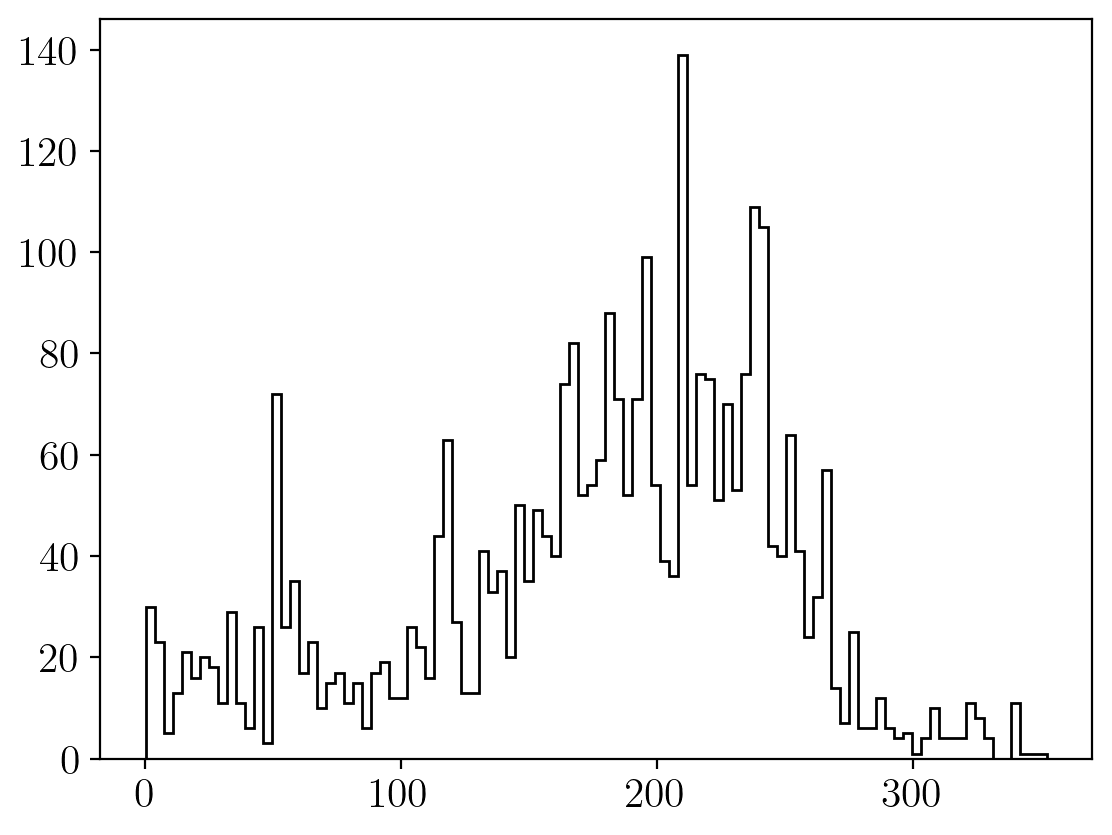

In [78]:
plt.hist(samples[:, 1], 100, color="k", histtype="step")

In [79]:
sampler.reset()
sampler.run_mcmc(state, 10000)

State([[ 1.05779385e-03  2.64364521e+02  5.00447197e+01]
 [ 1.00928307e-03  2.62725485e+02  5.16790098e+01]
 [ 1.02689609e-03  2.64027767e+02  4.97911805e+01]
 [ 9.03295455e-04  2.74322269e+02  4.53241313e+01]
 [ 1.02041126e-03  2.60860049e+02  5.52593542e+01]
 [ 1.08081621e-03  2.63298942e+02  5.61864435e+01]
 [ 1.03648603e-03  2.68516617e+02  4.19915620e+01]
 [ 8.95551532e-04  2.74923950e+02  4.73069609e+01]
 [ 9.56220422e-04  2.62791793e+02  4.80237776e+01]
 [ 1.01289805e-03  2.67967765e+02  4.52355465e+01]
 [ 1.04600119e-03  2.72012494e+02  4.72722834e+01]
 [ 9.77080744e-04  2.67239984e+02  4.77820457e+01]
 [ 1.02668613e-03  2.58764053e+02  5.10557487e+01]
 [ 9.33218889e-04  2.66582124e+02  4.31906751e+01]
 [ 1.07675358e-03  2.63079670e+02  5.09437376e+01]
 [ 1.00479151e-03  2.74055899e+02  4.26550114e+01]
 [ 1.06449950e-03  2.59610122e+02  5.26658684e+01]
 [ 1.00779416e-03  2.62706904e+02  4.39410443e+01]
 [ 1.04111359e-03  2.55351992e+02  4.71378549e+01]
 [ 9.36419182e-04  2.6107

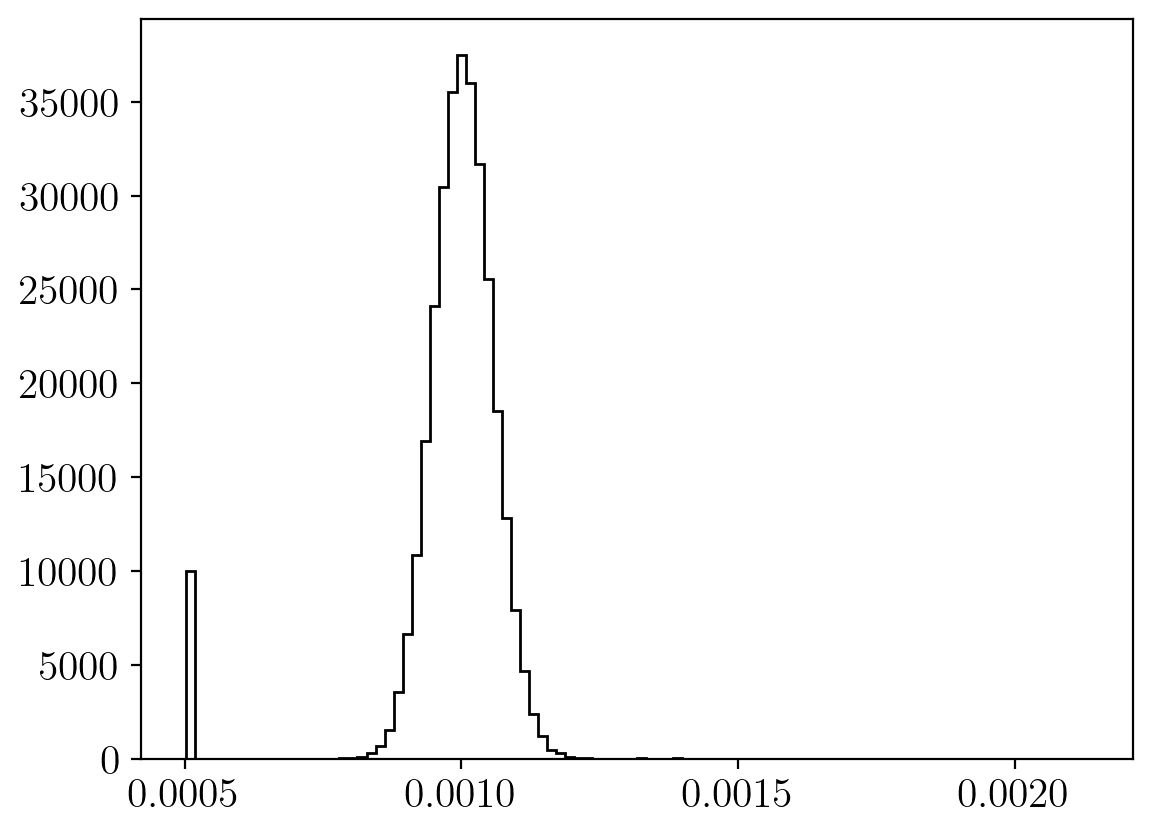

In [80]:
samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 0], 100, color="k", histtype="step")
plt.savefig('../plots/emcee_dip_g0p001_XG_A#.png',dpi=600)

In [81]:
np.savetxt('emcee_sample_dip_g0p001_XG_A#.txt',samples)

In [82]:
# samples = np.loadtxt('emcee_sample_dip_g0p001.txt')

In [83]:
samples[:,0]*=1e3

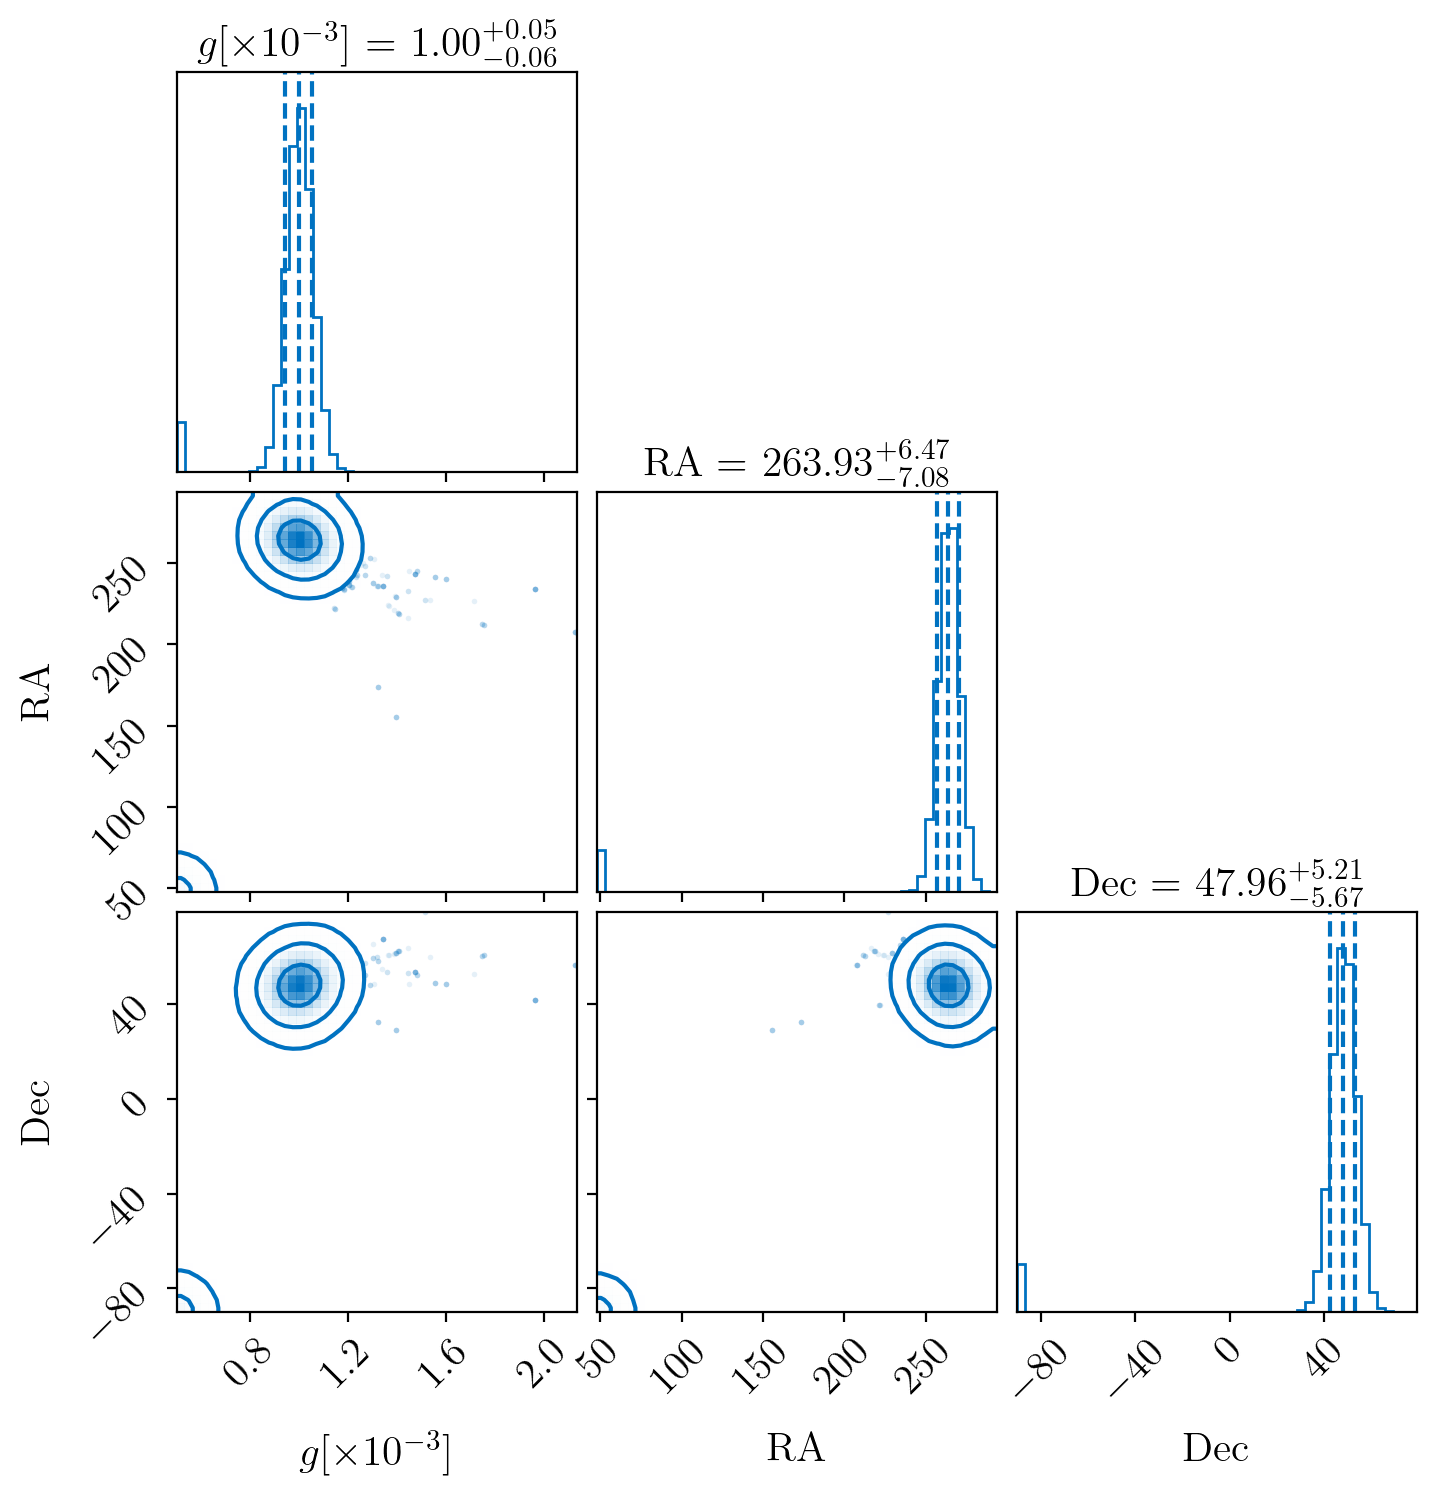

In [84]:
labels=[r'$g[\times 10^{-3}]$', 'RA', 'Dec']

fig = corner.corner(samples,quantiles=[0.16, 0.5, 0.84], show_titles=True, bins=50, smooth=2, label_kwargs=dict(fontsize=15), color='#0072C1', levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)), title_kwargs={"fontsize": 15},labels=labels)
plt.savefig('../plots/emcee_dip_g0p001_corner_XG_A#.pdf',bbox_inches='tight')

In [34]:
def logprob_dl_g_H0(H0glb, ra_arr, dec_arr, zs_arr, dl_mean, dl_std, Om0=0.3):
    H0 = H0glb[0]
    g = H0glb[1]
    l = H0glb[2]
    b = H0glb[3]

    if 0<=g<1 and 0<=l<360 and -90<=b<=90 and 10<H0<200:

        dipole_gal = SkyCoord(l*u.deg, b*u.deg, frame='galactic')
        dipole_ICRS = dipole_gal.transform_to('icrs')

        phi_dipole = dipole_ICRS.ra.value*np.pi/180
        theta_dipole = np.pi/2-dipole_ICRS.dec.value*np.pi/180

        nx_dipole = np.cos(phi_dipole)*np.sin(theta_dipole)
        ny_dipole = np.sin(phi_dipole)*np.sin(theta_dipole)
        nz_dipole = np.cos(theta_dipole)

        chi2 = 0

        for i in range(len(ra_arr)):
            phi = ra_arr[i]
            theta = np.pi/2-np.array(dec_arr[i])

            nx = np.cos(phi)*np.sin(theta)
            ny = np.sin(phi)*np.sin(theta)
            nz = np.cos(theta)

            dipole = g*(nx_dipole*nx + ny_dipole*ny + nz_dipole*nz)

            astropy_cosmology = FlatLambdaCDM(Om0=Om0,H0=H0)
            zt = (1+zs_arr[i])/(1+dipole) -1
            dl_0 = astropy_cosmology.luminosity_distance(zt).value
            dl_g = dl_0*(1+dipole)

            chi2 += (dl_mean[i]-dl_g)**2 / dl_std[i]**2
        
        logprob = -0.5*chi2

    else:
        logprob = -np.inf

    return logprob

In [35]:
nwalkers = 32
ndim = 4
p0 = np.random.rand(nwalkers, ndim)*np.array([190,1,360,180]) - np.array([-10,0,0,90])
print(p0)

[[ 1.09058543e+02  6.25432813e-01  1.66223247e+00 -1.06780129e+01]
 [ 1.27812281e+02  3.72597595e-01  9.12901369e+01 -8.65589740e+01]
 [ 4.84199673e+01  4.97099400e-01  2.61869872e+01  4.06752028e+01]
 [ 1.02269998e+02  7.64044698e-01  2.83165634e+02  2.70203427e-01]
 [ 1.99466384e+02  8.35691753e-01  4.14791178e+01  4.07132147e+01]
 [ 1.77994079e+02  6.75894724e-02  1.39362142e+02  7.91062398e+01]
 [ 5.34780264e+01  4.86598081e-02  3.28208120e+02  8.34607086e+01]
 [ 1.29335722e+02  6.69704248e-02  1.34584019e+02 -5.86221878e+01]
 [ 3.47127364e+01  3.43238730e-01  2.92191244e+02  3.56987604e+00]
 [ 8.49877514e+01  1.00587225e-01  1.61498331e+02 -2.80825016e+01]
 [ 1.09959005e+01  8.98894217e-01  1.02259925e+02  8.04949468e+01]
 [ 1.29376223e+02  8.99801431e-01  2.86448304e+01 -7.95700878e+01]
 [ 1.79953381e+02  1.97215270e-01  3.07737831e+02  2.70893512e+01]
 [ 1.80203602e+02  6.82378468e-02  2.37213503e+02 -6.44937786e+01]
 [ 1.00965880e+02  4.68833257e-01  3.47796302e+02  4.55283510e

In [36]:
logprob_dl_g_H0(p0[0], ra_mean, dec_mean, z0, dl_mean, dl_std)

-12305126.693876885

In [37]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob_dl_g_H0, args=[ra_mean, dec_mean, z0, dl_mean, dl_std])


In [38]:
state = sampler.run_mcmc(p0, 100)


(array([  3.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   2.,
          0.,   0.,   0.,   0.,   2.,   1.,   0.,   7.,   8.,   0.,   4.,
          1.,   5.,   5.,   0.,  83.,  95., 206., 219., 113., 115.,  78.,
         23.,  66.,  40.,  25.,  45.,  23.,  34.,  30.,  29.,  38.,  25.,
         50.,  50.,  79.,  42.,  29.,  21.,  35.,  29.,  45.,  33.,  30.,
         46.,  25.,  50.,  44.,  24.,  36.,  19.,   2.,  27.,  40.,  67.,
         39.,  53.,  47.,   4.,  17.,  67.,   9.,  38.,  24.,  19.,  12.,
         29.,  18.,  55.,  45.,  18.,   7.,  41.,  26.,  24.,  35.,  41.,
         90.,  41.,  25.,  29.,   7.,  30.,   1.,  10.,  20.,  11.,  29.,
         89.]),
 array([ 19.23271993,  21.03505657,  22.83739322,  24.63972986,
         26.44206651,  28.24440315,  30.04673979,  31.84907644,
         33.65141308,  35.45374973,  37.25608637,  39.05842301,
         40.86075966,  42.6630963 ,  44.46543294,  46.26776959,
         48.07010623,  49.87244288,  51.67477952,  53.47711616

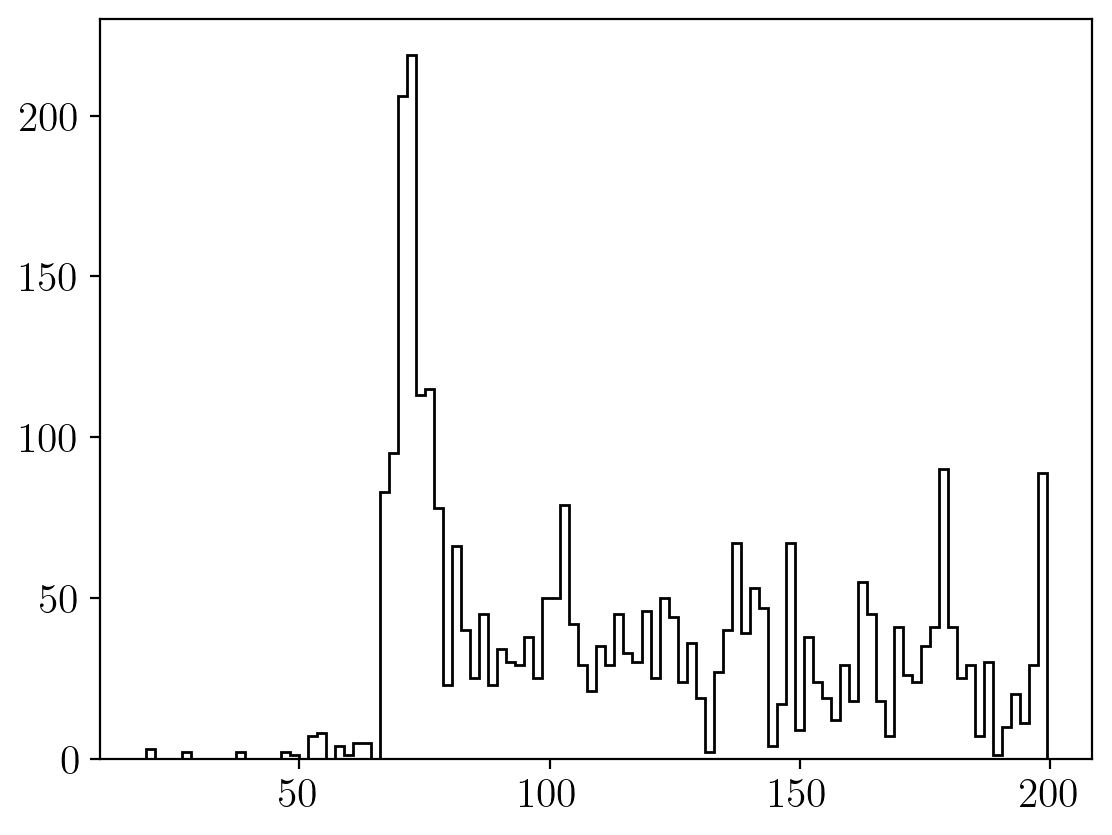

In [39]:
samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 0], 100, color="k", histtype="step")

In [40]:
sampler.reset()
sampler.run_mcmc(state, 10000)

State([[7.01278672e+01 1.01510950e-03 2.54461851e+02 5.27131135e+01]
 [6.99953872e+01 1.05112447e-03 2.58503372e+02 4.72931594e+01]
 [6.99962204e+01 1.00483141e-03 2.68583626e+02 3.60145024e+01]
 [7.00638933e+01 9.82124176e-04 2.61948790e+02 5.14521790e+01]
 [7.00372947e+01 9.96489392e-04 2.65354479e+02 4.59280299e+01]
 [6.99596573e+01 9.70332453e-04 2.70223075e+02 4.25727297e+01]
 [7.00653330e+01 1.08896567e-03 2.68765576e+02 5.81084521e+01]
 [7.00838646e+01 9.15558104e-04 2.80931893e+02 4.93575609e+01]
 [6.99723070e+01 1.06054621e-03 2.63516374e+02 5.18085426e+01]
 [7.00152480e+01 9.98334309e-04 2.62717540e+02 4.06524877e+01]
 [7.00364081e+01 9.82953885e-04 2.66761342e+02 5.30398802e+01]
 [6.99481732e+01 1.03795920e-03 2.67528919e+02 4.75969733e+01]
 [7.00480910e+01 9.04969430e-04 2.59192567e+02 4.79607516e+01]
 [7.01167633e+01 9.74166811e-04 2.71786485e+02 5.65084711e+01]
 [6.99448399e+01 9.73294525e-04 2.69440692e+02 4.75774874e+01]
 [6.98353356e+01 1.08335544e-03 2.64347417e+02 5.

Text(0, 0.5, 'Count')

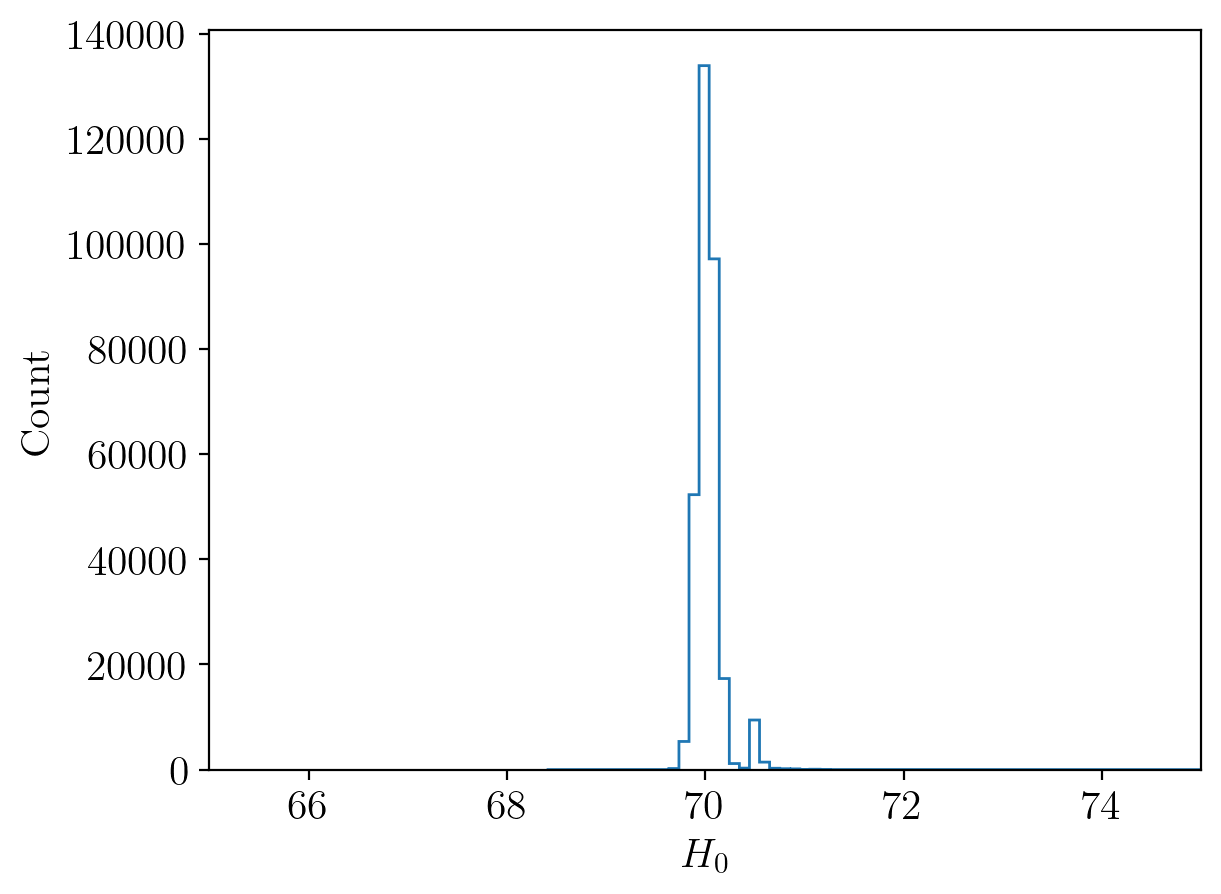

In [41]:
samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 0], 1000, histtype="step")
plt.xlim(65,75)
plt.xlabel(r'$H_0$')
plt.ylabel('Count')

In [42]:
np.savetxt('emcee_sample_dip_g0p001_H0_XG_A#.txt',samples)

In [43]:
samples[:,1]*=1e3

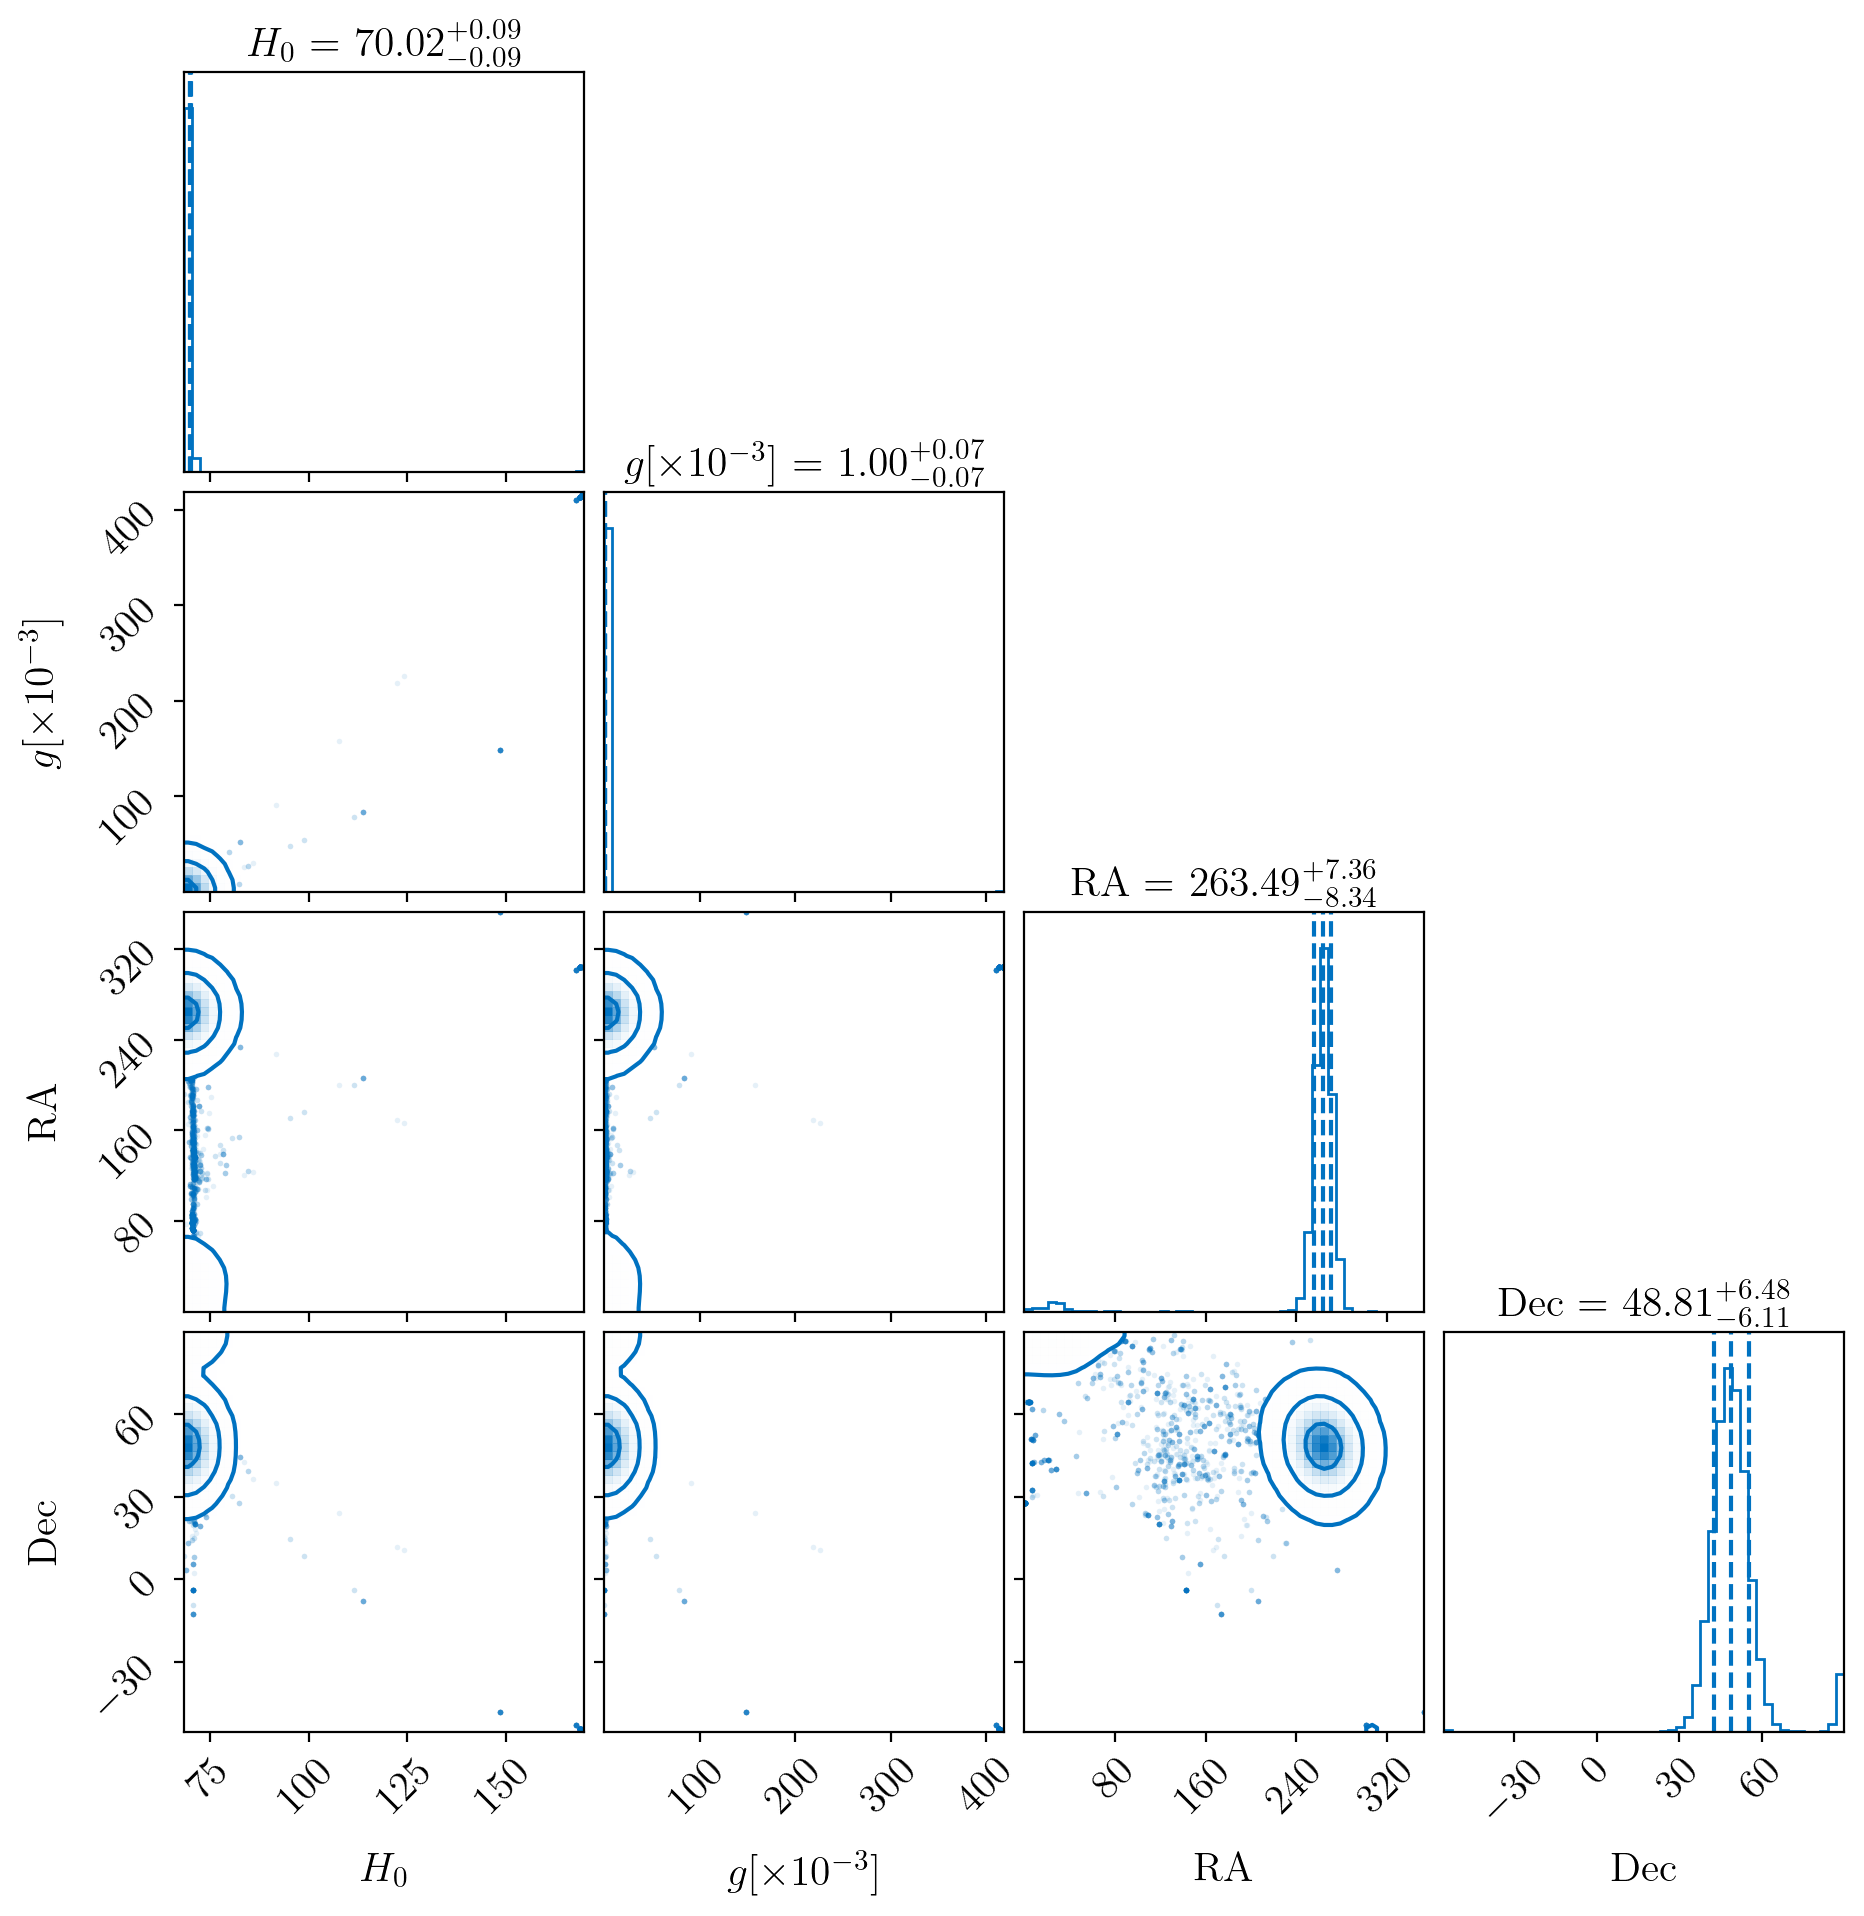

In [44]:
labels=[r'$H_0$',r'$g[\times 10^{-3}]$', 'RA', 'Dec']

fig = corner.corner(samples,quantiles=[0.16, 0.5, 0.84], show_titles=True, bins=50, smooth=2, label_kwargs=dict(fontsize=15), color='#0072C1', levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)), title_kwargs={"fontsize": 15},labels=labels)
plt.savefig('../plots/emcee_dip_g0p001_H0_corner_XG_A#.pdf',bbox_inches='tight')

In [45]:
samples = np.loadtxt('emcee_sample_dip_g0p001_H0_XG_A#.txt')

In [46]:
samples[:,1]*=1e3

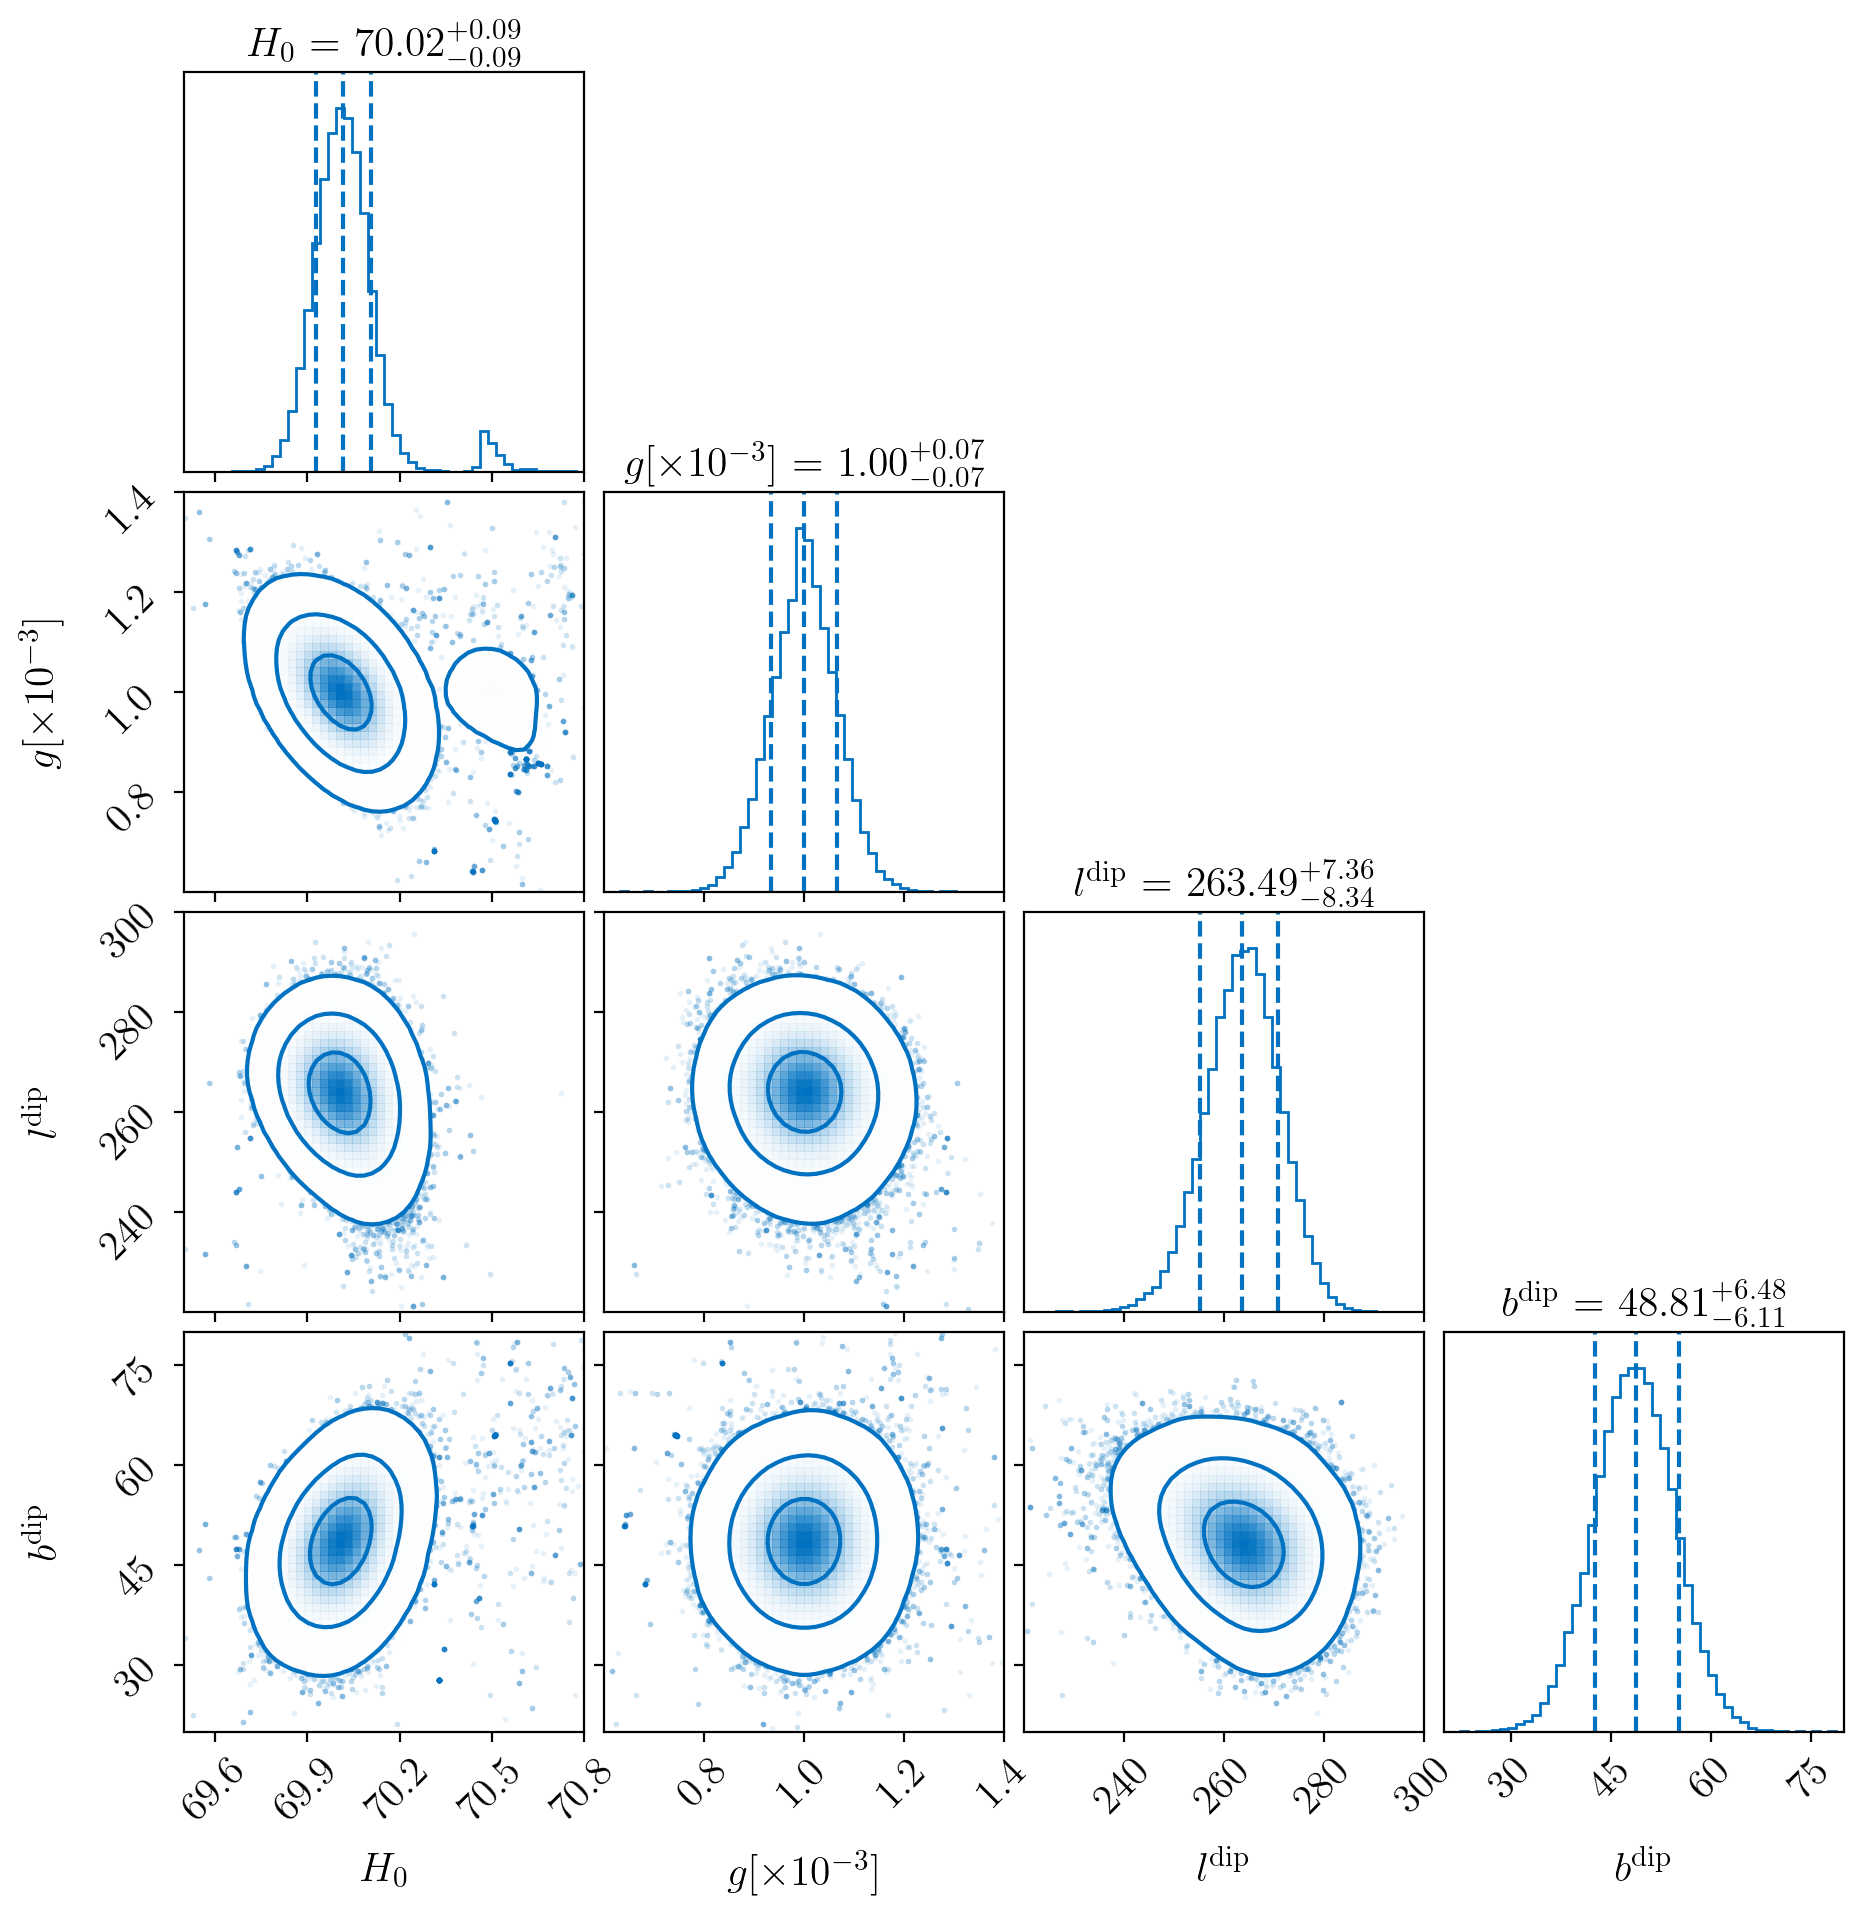

In [48]:
labels=[r'$H_0$',r'$g[\times 10^{-3}]$', r'$l^{\rm dip}$', r'$b^{\rm dip}$']

fig = corner.corner(np.array(samples), range=[(69.5,70.8),(0.6,1.4),(220,300),(20,80)], quantiles=[0.16, 0.5, 0.84], show_titles=True, bins=50, smooth=2, label_kwargs=dict(fontsize=15), color='#0072C1', levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)), title_kwargs={"fontsize": 15},labels=labels)
plt.savefig('../plots/emcee_dip_g0p001_H0_corner_XG_A#_zoom.pdf',bbox_inches='tight')

In [99]:
Omega_m=0.3
Omega_Lambda=0.7

integrand = lambda zz: 1./np.sqrt(Omega_m*(1+zz)**3 + Omega_Lambda)

dlH0overc = []
for i in range(len(index_all)):
    zarr = np.linspace(0,z0[i],1000)
    dlH0overc.append((1+z0[i])*simps(integrand(zarr), zarr))

H0 = np.array(dlH0overc)* C_SI*1e-3 / np.array(dl_mean)


/tmp/ipykernel_13312/1784687697.py:9: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  dlH0overc.append((1+z0[i])*simps(integrand(zarr), zarr))


In [100]:
import astropy.coordinates as coord
import matplotlib as mpl
plt.rcParams.update({'font.size': 15})
mpl.rcParams['text.usetex'] = True

%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

def coordinates_aitoff_plot(coords,H0):
    fig, ax = plt.subplots(figsize=(10, 4), 
                           subplot_kw=dict(projection="aitoff"))
    # fig.subplots_adjust(bottom=0.2)

    sph = coords.spherical
    cs = ax.scatter(-sph.lon.wrap_at(180*u.deg).radian,
                    sph.lat.radian,marker='.',s=100,
                    c=H0,cmap='coolwarm')

    def fmt_func_x(x, pos):
        val = coord.Angle(-x*u.radian).wrap_at(360*u.deg).degree
        return f'${val:.0f}' + r'^{\circ}$'

    xticker = mpl.ticker.FuncFormatter(fmt_func_x)
    ax.xaxis.set_major_formatter(xticker)
    ax.xaxis.set_ticks([-np.pi*2/3,-np.pi/3,0,np.pi/3,np.pi*2/3])
    # ax.yaxis.set_ticks([-np.pi/3,-np.pi/6,0,np.pi/3,np.pi/6])

    ax.grid()
    
    cb = fig.colorbar(cs)
    cb.set_label(r'$H_0~[{\rm km}~{\rm s}^{-1}~{\rm Mpc}^{-1}]$')
    cb.set_ticks([min(H0),70,max(H0)])
    # plt.clim(-0.01,0.01)
    
    return fig, ax

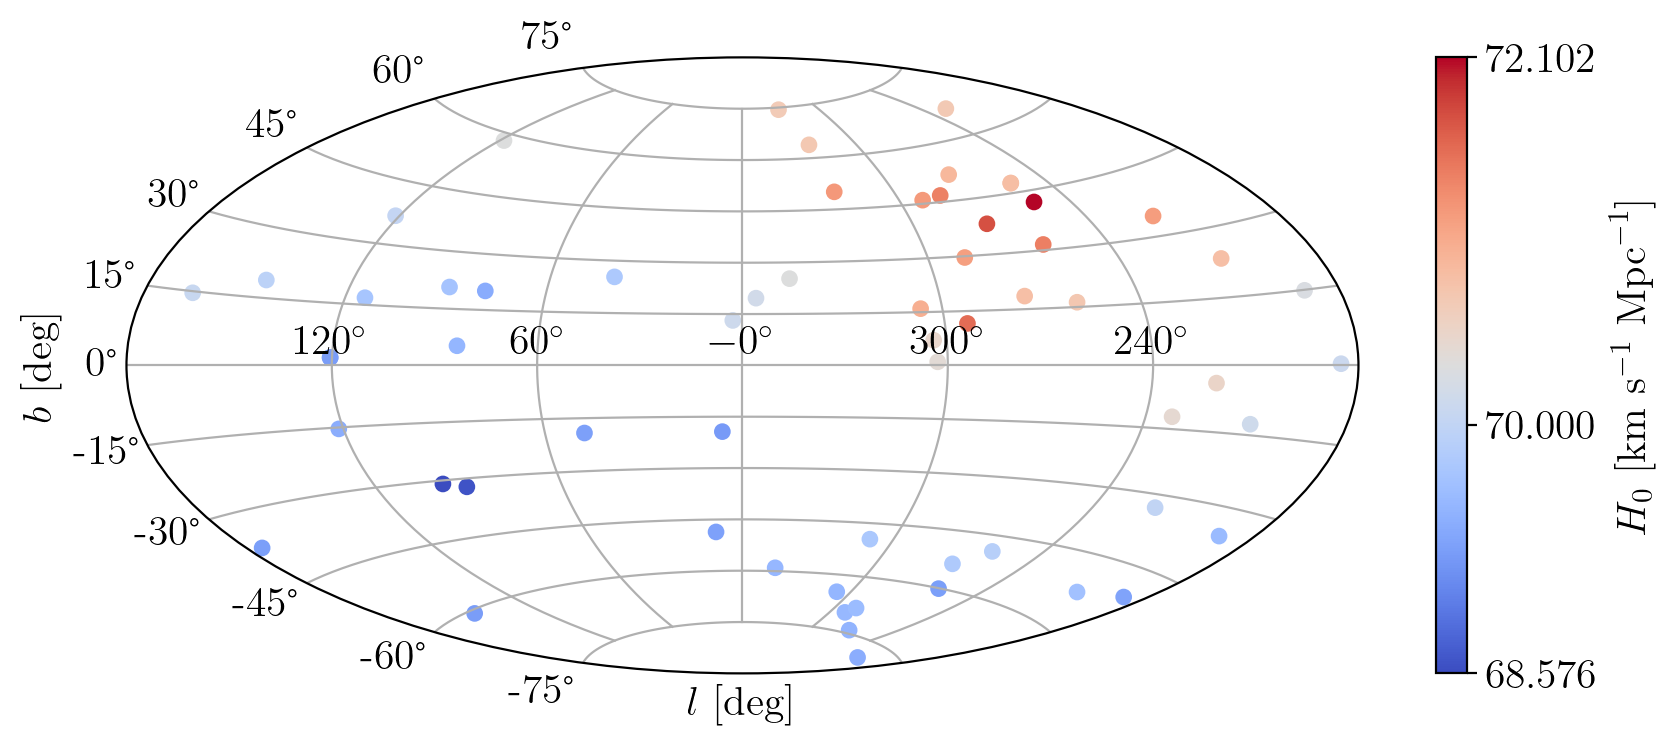

In [101]:
coord_golden = SkyCoord(ra_mean*u.radian, dec_mean*u.radian, frame='icrs')

fig, ax = coordinates_aitoff_plot(coord_golden.galactic,H0);
ax.set_xlabel('$l$ [deg]')
ax.set_ylabel('$b$ [deg]')
plt.savefig('../plots/H0_XG_A#_golden_g0p001.png',dpi=600)